In [1]:
#import keras,os
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
#from keras.preprocessing.image import ImageDataGenerator
#import numpy as np

In [1]:
#import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from tensorflow.keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from skimage.color import gray2rgb

SIZE = 256  #Resize images

# Extract the training images and labels 
data = ['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/A/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/A')]
data.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/LL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/LL')])
data.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/RL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/RL')])
data.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/TA/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/TA')])
data.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/W/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Train/W')])

train_images = []
for x in range(len(data)):
    img = cv2.imread(data[x],0)
    test = gray2rgb(img)
    test = cv2.resize(test, (256,256), interpolation = cv2.INTER_AREA)
    train_images.append(test)
    
train_labels = []
train_labels.extend('A' for i in range(637))
train_labels.extend('LL' for i in range(627))
train_labels.extend('RL' for i in range(660))
train_labels.extend('TA' for i in range(645))
train_labels.extend('W' for i in range(630))   

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Extract the test images and labels 
datat = ['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/A/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/A')]
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/LL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/LL')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/RL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/RL')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/TA/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/TA')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/W/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Preprocessed/Test/W')])

test_images = []
for x in range(len(datat)):
    img = cv2.imread(datat[x],0)
    test = gray2rgb(img)
    test = cv2.resize(test, (256,256), interpolation = cv2.INTER_AREA)
    test_images.append(test)
    
test_labels = []
test_labels.extend('A' for i in range(164))
test_labels.extend('LL' for i in range(171))
test_labels.extend('RL' for i in range(141))
test_labels.extend('TA' for i in range(155))
test_labels.extend('W' for i in range(169))    

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
#train_ds = preprocess_input(x_train) 
#test_ds = preprocess_input(x_test)
#train_ds = x_train
#test_ds = x_test

In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [4]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1638450   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
Total params: 16,354,263
Trainable params: 1,639,575
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
#optimizer = tensorflow.keras.optimizers.Adam(lr=0.01)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

r = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), batch_size=16, callbacks=[es])
# model.fit(train_ds, y_train, batch_size=32, epochs=100, callbacks=[es])

Epoch 1/10
200/200 [==============================] - 1656s 8s/step - loss: 1.1040 - accuracy: 0.5861 - val_loss: 0.6254 - val_accuracy: 0.7613
Epoch 2/10
200/200 [==============================] - 1939s 10s/step - loss: 0.5639 - accuracy: 0.7756 - val_loss: 0.4977 - val_accuracy: 0.7775
Epoch 3/10
200/200 [==============================] - 1357s 7s/step - loss: 0.3844 - accuracy: 0.8537 - val_loss: 0.5405 - val_accuracy: 0.7750
Epoch 4/10
200/200 [==============================] - 918s 5s/step - loss: 0.3090 - accuracy: 0.8853 - val_loss: 0.3992 - val_accuracy: 0.8450
Epoch 5/10
200/200 [==============================] - 896s 4s/step - loss: 0.2354 - accuracy: 0.9181 - val_loss: 0.4109 - val_accuracy: 0.8400
Epoch 6/10
200/200 [==============================] - 1041s 5s/step - loss: 0.2078 - accuracy: 0.9244 - val_loss: 0.4436 - val_accuracy: 0.8388
Epoch 7/10
200/200 [==============================] - 856s 4s/step - loss: 0.1929 - accuracy: 0.9309 - val_loss: 0.3795 - val_accuracy: 0

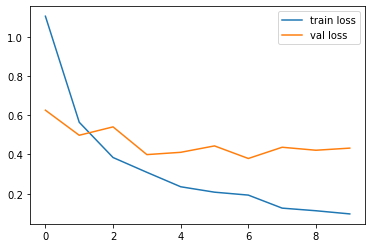

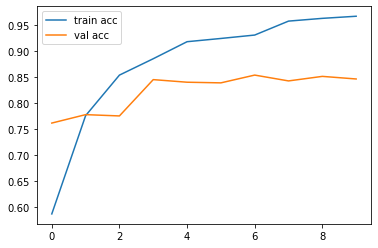

<Figure size 432x288 with 0 Axes>

In [7]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
model.save('vgg_preprocessed_256_10_16.h5')

### Load Model

In [ ]:
model = load_model("C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Model-Training/vgg_preprocessed_256_10_16.h5")

In [ ]:
# Extract the images and labels 
datat = ['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/A/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/A')]
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/LL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/LL')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/RL/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/RL')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/TA/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/TA')])
datat.extend(['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/W/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/W')])
#datat = ['C:/Users/leona/OneDrive/DSA4199/NIST-Classification/TEST/LEONA/Brown/Preprocessed/' + s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/TEST/LEONA/Brown/Preprocessed')]

test_images = []
for x in range(len(datat)):
    img = cv2.imread(datat[x],0)
    test = gray2rgb(img)
    test = cv2.resize(test, (256,256), interpolation = cv2.INTER_AREA)
    test_images.append(test)
    
#Convert lists to arrays                
x_test = np.array(test_images)
x_test = x_test / 255.0

predictions = model.predict(x_test)

In [ ]:
fclass = []
import numpy as np
for i in range(len(predictions)):
    ind = np.argmax(predictions[i])
    if ind == 0:
        fclass.append('A')
    elif ind == 1:
        fclass.append('LL')
    elif ind == 2:
        fclass.append('RL')
    elif ind == 3:
        fclass.append('TA')
    elif ind == 4:
        fclass.append('W')
        

In [ ]:
name = [s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/A')]
name.extend([s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/LL')])
name.extend([s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/RL')])
name.extend([s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/TA')])
name.extend([s for s in os.listdir('C:/Users/leona/OneDrive/DSA4199/NIST-Classification/Training - Raw - Pepper - 0.15/Preprocessed/Test/W')])

test_labels = []
test_labels.extend('A' for i in range(164))
test_labels.extend('LL' for i in range(171))
test_labels.extend('RL' for i in range(141))
test_labels.extend('TA' for i in range(155))
test_labels.extend('W' for i in range(169))

# importing pandas as pd  
import pandas as pd  
       
df = {'File': name, 'Predicted Class':fclass, 'True Class':test_labels}
df = pd.DataFrame(df)
# saving the dataframe 
df.to_csv('Training - Raw - Pepper - 0.15.csv') 